<a href="https://colab.research.google.com/github/Sirikorn17/229352-StatisticalLearning/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_loader

In [8]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


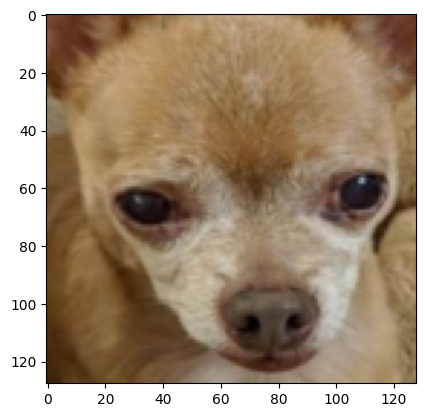

In [9]:
plt.imshow(X[0].numpy().transpose(1, 2, 0))


#### Visualize the first four images in the batch

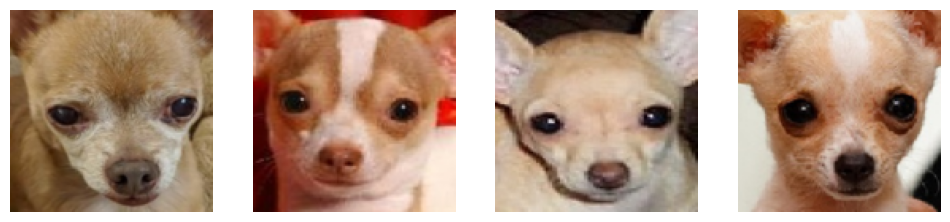

tensor([0, 0, 0, 0])


In [10]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [11]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(128 * 128 * 3, 128) # Hidden layer 1
    self.act1 = nn.ReLU()
    self.linear2 = nn.Linear(128, 64) # Hidden layer 2
    self.act2 = nn.ReLU()
    self.linear3 = nn.Linear(64, 32) # Hidden layer 3
    self.act3 = nn.ReLU()
    self.output_layer = nn.Linear(32, 1) # Output layer
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    x = self.act2(x)
    x = self.linear3(x)
    x = self.act3(x)
    x = self.output_layer(x)
    x = self.sigmoid(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [12]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [13]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [14]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [15]:
learning_rate = 1e-2

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [16]:
train_batches = iter(train_loader)
X, y = next(train_batches)

In [17]:
X, y = next(train_batches)


#### Make a prediction on the minibatch (Forward pass)

In [18]:
y_hat = model(X)
print(y_hat.shape)
print(y.shape)

y_hat = y_hat[:, 0]
y = y.to(torch.float32) #

torch.Size([10, 1])
torch.Size([10])

torch.Size([10, 1])
torch.Size([10])


torch.Size([10])

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [19]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())

#### Calculate the gradient (Backward pass)

In [20]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss_backward = loss.backward()

In [21]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],

In [22]:
for param in model.parameters():
  print(param.grad)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0.,

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [23]:
# Manually update the weights using the gradient descent rule

with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad
# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [24]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [25]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.693397581577301]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

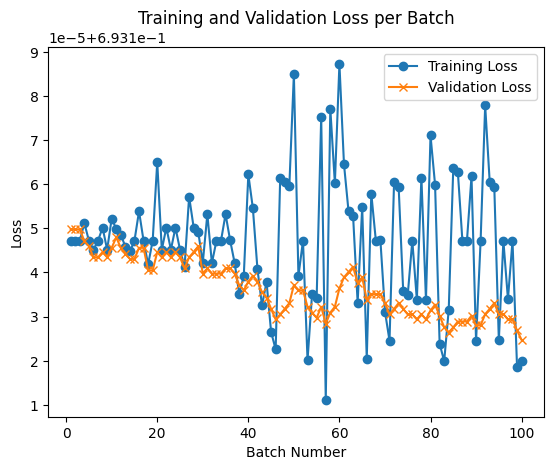

In [26]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

# 1

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(128 * 128 * 3, 128) # Hidden layer 1
    self.act1 = nn.ReLU()
    self.linear2 = nn.Linear(128, 64) # Hidden layer 2
    self.act2 = nn.ReLU()
    self.linear3 = nn.Linear(64, 32) # Hidden layer 3
    self.act3 = nn.ReLU()
    self.output_layer = nn.Linear(32, 1) # Output layer
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    x = self.act2(x)
    x = self.linear3(x)
    x = self.act3(x)
    x = self.output_layer(x)
    x = self.sigmoid(x)
    return x

# 2

In [28]:
criterion = nn.BCELoss()
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = SimpleLogisticRegression()  # ใช้คลาสจากข้อ 1

    # init น้ำหนัก/ไบอัสเป็นศูนย์
    with torch.no_grad():
        for layer in model.modules():
            if isinstance(layer, nn.Linear):
                layer.weight.zero_()
                if layer.bias is not None:
                    layer.bias.zero_()

    train_losses, val_losses = [], []
    epochs = 10

    for epoch in range(epochs):
        # Train
        model.train()
        for X, y in train_loader:
            y_hat = model(X)[:, 0]
            y = y.to(torch.float32)

            loss = criterion(y_hat, y)
            train_losses.append(loss.item())

            # backprop
            loss.backward()

            # manual gradient descent
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad

            # เคลียร์ gradient
            model.zero_grad()

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for Xv, yv in val_loader:
                yv_hat = model(Xv)[:, 0]
                yv = yv.to(torch.float32)
                vloss = criterion(yv_hat, yv).item()
                epoch_val_loss += vloss

        val_losses.append(epoch_val_loss / len(val_loader))

    results[lr] = {"train_losses": train_losses, "val_losses": val_losses}

print("Training finished for all learning rates.")


Training with learning rate: 0.01
Training with learning rate: 0.001
Training with learning rate: 0.0001
Training with learning rate: 1e-05
Training finished for all learning rates.


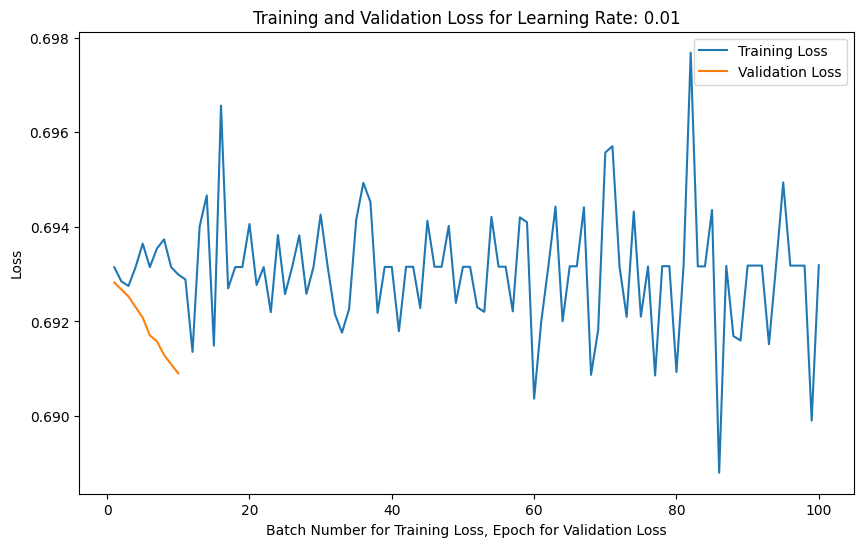

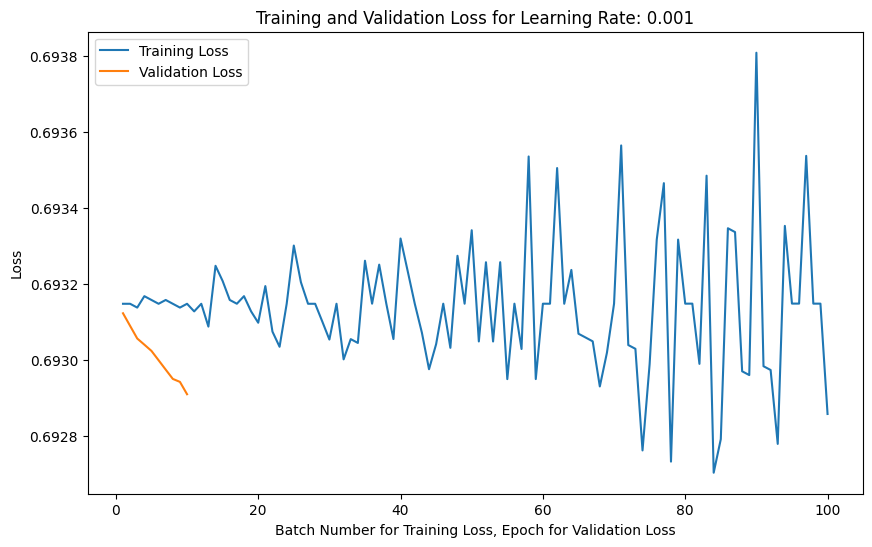

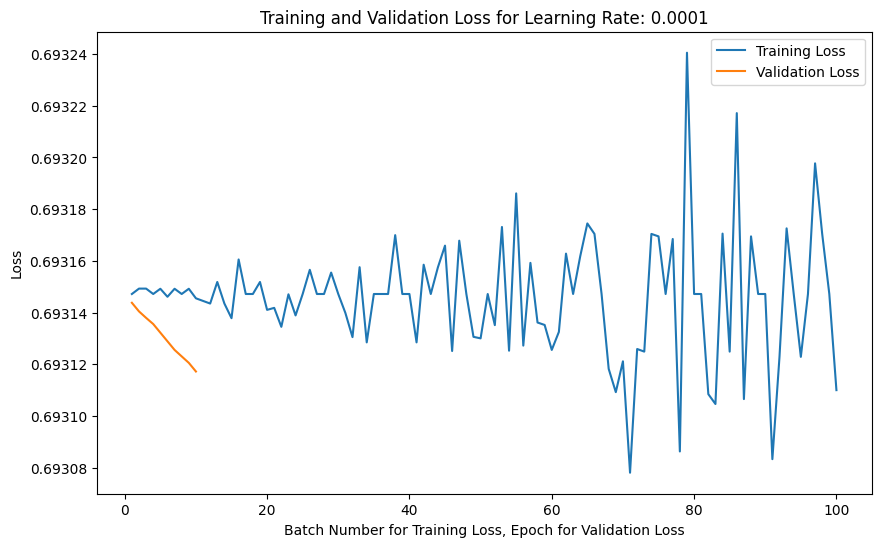

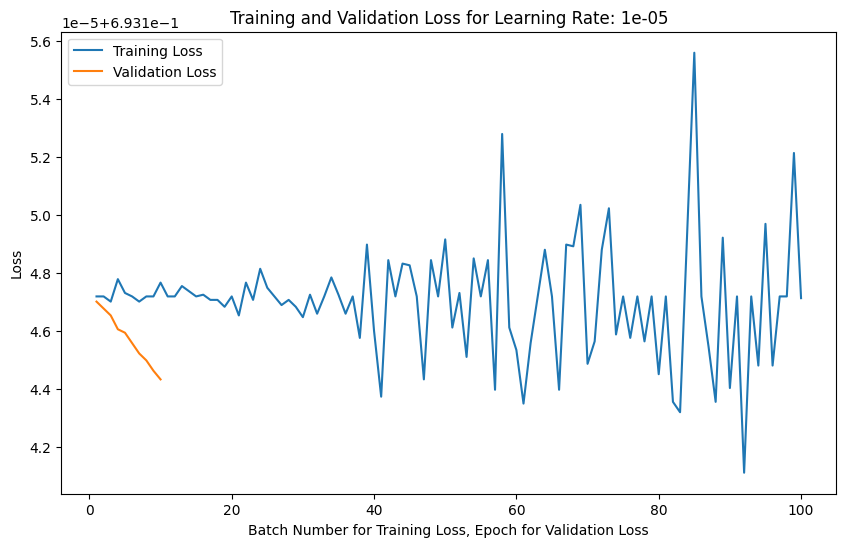

In [29]:
# Plot the training and validation loss for each learning rate
for lr, losses in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses['train_losses']) + 1), losses['train_losses'], label='Training Loss')
    # Since validation is done per epoch, the x-axis for validation loss will be epochs
    plt.plot(range(1, len(losses['val_losses']) + 1), losses['val_losses'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for Learning Rate: {lr}')
    plt.xlabel('Batch Number for Training Loss, Epoch for Validation Loss')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

**2.1 What value of learning rate do you think is the best? Please explain your reason.**

คิดว่า 1e-3 ให้ผลดีที่สุด เนื่องจากเส้นกราฟของ training loss และ validation loss ลดลงอย่างต่อเนื่องและมีเสถียรภาพ ไม่แกว่งแรง และยังคงลดลงสอดคล้องกันทั้งสองชุดข้อมูล แสดงว่าโมเดลสามารถเรียนรู้ได้ดีและมีความสามารถในการ generalize ไปยังข้อมูล validation ได้

**2.2 What happens to the training losses if your learning rate is too large?**

เมื่อกำหนดค่า learning rate ที่สูงเกินไป ผลลัพธ์จากกราฟแสดงให้เห็นว่า training loss มีการแกว่งขึ้นลงมากและไม่ลดลงอย่างสม่ำเสมอ ทำให้โมเดลไม่สามารถหาค่าน้ำหนักที่เหมาะสมได้ เกิดอาการ overshooting หรือแม้กระทั่ง diverge (ค่า loss ไม่ลดลงเลย) ซึ่งทำให้ผลการเรียนรู้ไม่ดี

**2.3 What happens to the training losses if your learning rate is too small?**

เมื่อกำหนดค่า learning rate ที่เล็กเกินไป loss จะลดลงช้ามาก หรือแทบไม่เปลี่ยนแปลงในจำนวน epoch ที่เท่ากันกับค่า learning rate อื่น ๆ แสดงให้เห็นว่าโมเดลปรับตัวช้าเกินไป การเรียนรู้จึงเกิดขึ้นช้ามาก (slow convergence) หากเพิ่มจำนวน epoch อาจได้ผลลัพธ์ที่ดีขึ้น แต่ต้องใช้เวลาฝึกนานมาก

# 3

In [30]:
# calculate test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        y_prob = model(X_test)[:, 0]
        y_pred = (y_prob > 0.5).int()
        correct += (y_pred == y_test).sum().item()
        total   += y_test.size(0)
acc = correct / total
print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.5667


4

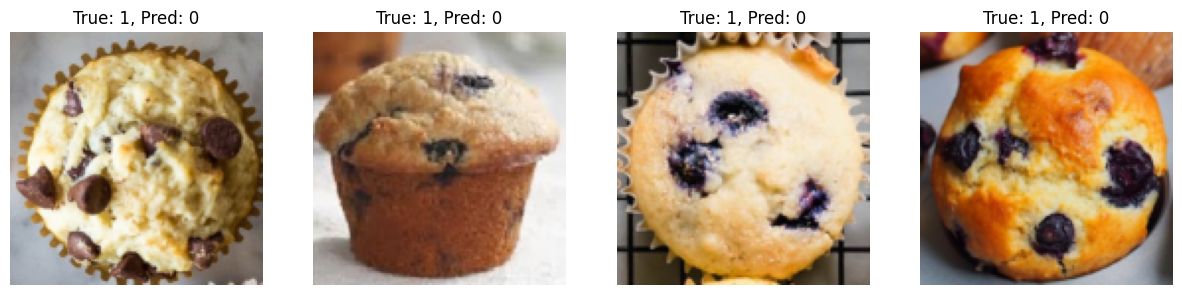

In [31]:
import matplotlib.pyplot as plt

model.eval()
misclassified_images = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for X_test, y_test in test_loader:  # โหลด test set ทั้งหมด
        y_prob = model(X_test)[:, 0]
        y_pred = (y_prob > 0.5).int()

        mask = (y_pred != y_test)  # เลือกรูปที่ทำนายผิด
        misclassified_images.extend(X_test[mask].numpy())
        true_labels.extend(y_test[mask].numpy())
        pred_labels.extend(y_pred[mask].numpy())

n_show = min(4, len(misclassified_images))
fig, axes = plt.subplots(1, n_show, figsize=(15, 5))
for i in range(n_show):
    img = misclassified_images[i].transpose(1, 2, 0)  # แปลงจาก (C,H,W) -> (H,W,C)
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
    axes[i].axis("off")

plt.show()
